# Ising model


The Ising Hamiltonian can be written as, 

$$ 
\mathcal{H} = -J \sum_{\langle i j \rangle} S_{i} S_{j}.  
$$

* The spins $S_{i}$ can take values $\pm 1$,
*  $\langle i j \rangle$ implies nearest-neighbor interaction only, 
* $J>0$ is the strength of exchange interaction,
 

The system undergoes a 2nd order phase transition at the critical temperature $T_{c}$.

In equilibrium, for temperature less than $T_{c}$, the system magnetises, and the state  is called the ferromagnetic or the ordered state. For temperature greater than $T_{c}$, the system is in the disordered or the paramagnetic state.
 
The order parameter

$$ m = \frac{\langle S \rangle}{N}, $$

for this system is the average magnetization. 

It distinguished the two phases. The order parameter is zero in the disordered state while non-zero in the ordered, ferromagnetic, state. 

## Ising model in 2D
The following code simulates the Ising model in 2D.

Energy, Magnetization, Specific Heat and Susceptibility have been calculated and plotted.

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt

#----------------------------------------------------------------------
##  BLOCK OF FUNCTIONS USED IN THE MAIN CODE
#----------------------------------------------------------------------

def initialstate(N):   
    ''' generates a random spin configuration for initial condition'''
    state = 2*np.random.randint(2, size=(N,N))-1
    return state


def mcmove(config, beta):
    '''Monte Carlo move using Metropolis algorithm '''
    for i in range(N):
        for j in range(N):
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                s =  config[a, b]
                nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                cost = 2*s*nb
                if cost < 0:
                    s *= -1
                elif rand() < np.exp(-cost*beta):
                    s *= -1
                config[a, b] = s
    return config


def calcEnergy(config):
    '''Energy of a given configuration'''
    energy = 0
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j] + config[i,(j-1)%N]
            energy += -nb*S
    return energy/4.


def calcMag(config):
    '''Magnetization of a given configuration'''
    mag = np.sum(config)
    return mag

In [2]:
## change the parameter below if you want to simulate a smaller system
nt      = 2**8        # number of temperature points
N       = 2**4        # size of the lattice, N x N
eqSteps = 2**10       # number of MC sweeps for equilibration
mcSteps = 2**10       # number of MC sweeps for calculation

n1, n2  = 1.0/(mcSteps*N*N), 1.0/(mcSteps*mcSteps*N*N)
tm = 2.269;    T=np.random.normal(tm, .64, nt)
T  = T[(T>1.2) & (T<3.8)];    nt = np.size(T)

Energy       = np.zeros(nt);   Magnetization  = np.zeros(nt)
SpecificHeat = np.zeros(nt);   Susceptibility = np.zeros(nt)


#----------------------------------------------------------------------
#  MAIN PART OF THE CODE
#----------------------------------------------------------------------
for m in range(len(T)):
    E1 = M1 = E2 = M2 = 0
    config = initialstate(N)
    iT=1.0/T[m]; iT2=iT*iT;
    
    for i in range(eqSteps):         # equilibrate
        mcmove(config, iT)           # Monte Carlo moves

    for i in range(mcSteps):
        mcmove(config, iT)           
        Ene = calcEnergy(config)     # calculate the energy
        Mag = calcMag(config)        # calculate the magnetisation

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag 
        E2 = E2 + Ene*Ene

        Energy[m]         = n1*E1
        Magnetization[m]  = n1*M1
        SpecificHeat[m]   = (n1*E2 - n2*E1*E1)*iT2
        Susceptibility[m] = (n1*M2 - n2*M1*M1)*iT

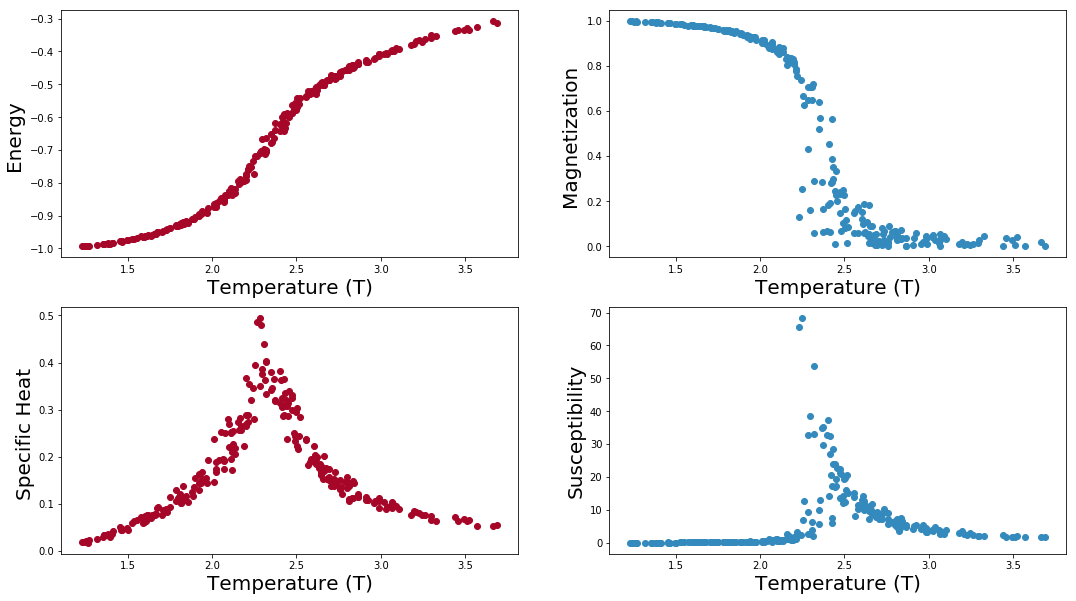

In [3]:
f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1 );
plt.plot(T, Energy, 'o', color="#A60628");
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);

sp =  f.add_subplot(2, 2, 2 );
plt.plot(T, abs(Magnetization), 'o', color="#348ABD");
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Magnetization ", fontsize=20);

sp =  f.add_subplot(2, 2, 3 );
plt.plot(T, SpecificHeat, 'o', color="#A60628");
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Specific Heat ", fontsize=20);

sp =  f.add_subplot(2, 2, 4 );
plt.plot(T, Susceptibility, 'o', color="#348ABD");
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Susceptibility", fontsize=20);

**Note:** A better optimized version of the above code can be found [here](https://github.com/rajeshrinet/compPhy/tree/master/ising/pyImplementation). One of the difference being that we do not calculate the exponential in the loop in the optimized cython version. The way it is less expensive in terms of computation time, as we do not have to function call $N\times N$ times. In doing so, we use the fact that spin can take values 1 and -1. Thus, there are only two possibilities for an energy increasing move. They are:

In [ ]:
# change in energy is 8J
#    d          d               u          u        
# d  d  d => d  u  d   or    u  u  u => u  d  u  
#    d          d               u          u 
#     
# change in energy is 4J
#    d          d               u          u        
# d  d  u => d  u  u   or    u  u  d => u  d  d   
#    d          d               u          u 
#     
# Here u and d are used for up and down configuration of the spins

## Below we plot the snapshots of the configurations

We start with a random initial condition and then plot the instantaneous configurations, as the system [coarsens](https://speakerdeck.com/rajeshrinet/coarsening-phenomena) to its equilibrium state.

In [4]:
%matplotlib inline
# Simulating the Ising model
from __future__ import division
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt

class Ising():
    ''' Simulating the Ising model '''    
    ## monte carlo moves
    def mcmove(self, config, N, beta):
        ''' This is to execute the monte carlo moves using 
        Metropolis algorithm such that detailed
        balance condition is satisified'''
        for i in range(N):
            for j in range(N):            
                    a = np.random.randint(0, N)
                    b = np.random.randint(0, N)
                    s =  config[a, b]
                    nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                    cost = 2*s*nb
                    if cost < 0:	
                        s *= -1
                    elif rand() < np.exp(-cost*beta):
                        s *= -1
                    config[a, b] = s
        return config
    
    def simulate(self):   
        ''' This module simulates the Ising model'''
        N, temp     = 64, .4        # Initialse the lattice
        config = 2*np.random.randint(2, size=(N,N))-1
        f = plt.figure(figsize=(15, 15), dpi=80);    
        self.configPlot(f, config, 0, N, 1);
        
        msrmnt = 1001
        for i in range(msrmnt):
            self.mcmove(config, N, 1.0/temp)
            if i == 1:        self.configPlot(f, config, i, N, 2);
            if i == 4:       self.configPlot(f, config, i, N, 3);
            if i == 32:      self.configPlot(f, config, i, N, 4);
            if i == 100:     self.configPlot(f, config, i, N, 5);
            if i == 1000:    self.configPlot(f, config, i, N, 6);
                 
                    
    def configPlot(self, f, config, i, N, n_):
        ''' This modules plts the configuration once passed to it along with time etc '''
        X, Y = np.meshgrid(range(N), range(N))
        sp =  f.add_subplot(3, 3, n_ )  
        plt.setp(sp.get_yticklabels(), visible=False)
        plt.setp(sp.get_xticklabels(), visible=False)      
        plt.pcolormesh(X, Y, config, cmap=plt.cm.RdBu);
        plt.title('Time=%d'%i); plt.axis('tight')    
    plt.show()

In [5]:
rm = Ising()

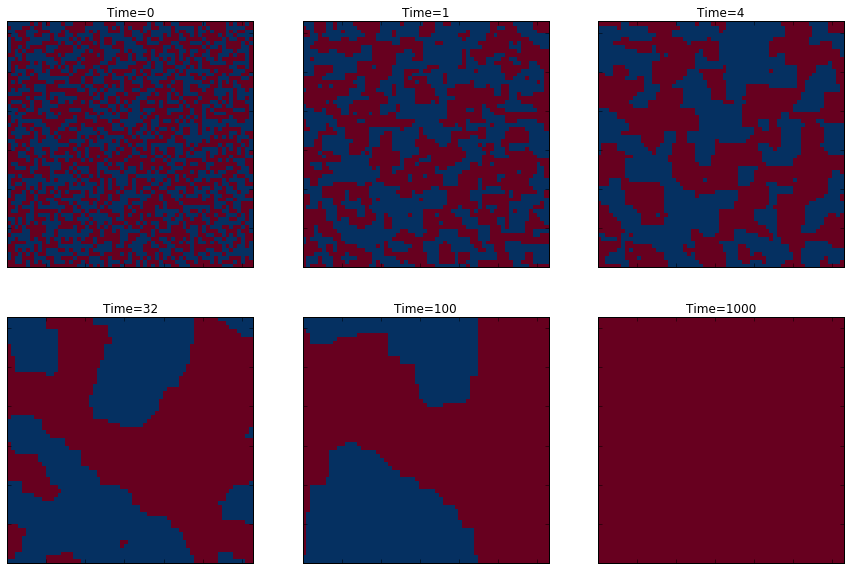

In [6]:
rm.simulate()

## Kinetic Ising Models


* Ising model has no Hamiltonian given dynamics. For kinetics we assume that an associated heat bath generates
    spin flip $( S_{i} \rightarrow - S_{i})$. 
* The kinetics can be 
    * The spin system, which have a non-conserved kinetics. At the microscopic level, spin-flip Glauber model is used to describe the non-conserved kinetics of the paramagnetic to ferromagnetic transition
    * The binary (AB) mixture or Lattice Gas. The spin-exchange Kawasaki model is used to describe the conserved kinetics of binary mixtures at the microscopic level


* Purely dissipative and stochastic models are ofter referred to as Kinetic Ising models. 
* At the coarse-grained level the respective order parameters, $\phi(\vec{r},t)$ are used to describe the dynamics. 
  

### Domain Growth with non-conserved kinetics

* At $t = 0,$ a paramagnetic phase is quenched below the critical temperature $T_{c}$.
* The paramagnetic state is no longer the preferred equilibrium state.
* The far-from-equilibrium, homogeneous, state evolves towards its new equilibrium state by separating in domains.
* These domains coarsen with time and are characterized by length scale $L(t)$.
* A finite system becomes ordered in either of two equivalent states as $t \rightarrow \infty$. 
* The simplest kinetics Ising model for non-conserved scalar field $\phi(\vec{r})$ is the time dependent Ginzburg-Landau (TDGL) model. 


### TDGL equation

The equation of motion for $\phi$ can be written as:

$$ \frac{\partial \phi}{\partial t} = -\Gamma \frac{\delta \mathcal{F}}{\delta \phi} +\theta(\vec{r},t)$$

where $\frac{\delta \mathcal{F}}{\delta \phi}$ denotes functional derivative of free-energy functional


$$ \mathcal{F(\phi)} = \int  \left[ a\phi^2 + b \phi^4 + \frac{1}{2}K(\nabla\phi)^{2}\right]$$


For  $ T < T_{c} $ we can write TDGL in terms of rescaled variables as

$$ \frac{\partial \phi}{\partial t} = \phi-\phi^{3}+ \nabla^{2}\phi $$


In the next section we will simulate the TDGL equation.

In [6]:
# Simulating the TDGL equation
# This example uses the 5-point Laplacian discretization from 
# [here](https://github.com/ketch/finite-difference-course)
#
%matplotlib inline
import numpy as np
from __future__ import division
from scipy.sparse import spdiags,linalg,eye
import matplotlib.pyplot as plt


a, b, k = 0, 1.0, 100.0
dh, dt  = 1.0, 1e-3
N, T    = 1024, 10001

class TDGL():
    '''
    Class to solve a PDE 
    '''
    def mu(self, u):
        return a*u + b*u*u*u 

    def laplacian(self, N):
        '''Construct a sparse matrix that applies the 5-point Laplacian discretization'''
        e=np.ones(N**2)
        e2=([1]*(N-1)+[0])*N
        e3=([0]+[1]*(N-1))*N
        h=dh
        A=spdiags([-4*e,e2,e3,e,e],[0,-1,1,-N,N],N**2,N**2)
        A/=h**2
        return A

    def integrate(self, L, x, y, u):
        '''  simulates the equation and plots it at different instants '''
        
        f = plt.figure(figsize=(15, 15), dpi=80);    

        for i in range(T):          
            u = u - dt*(self.mu(u) - k*L.dot(u))
            
            if (i==0):      self.configPlot(x, y, u, f, 1, i);
            if (i==1):      self.configPlot(x, y, u, f, 2, i);
            if (i==10):     self.configPlot(x, y, u, f, 3, i);
            if (i==100):    self.configPlot(x, y, u, f, 4, i);
            if (i==1000):   self.configPlot(x, y, u, f, 5, i);
            if (i==10000):  self.configPlot(x, y, u, f, 6, i);
     
    def configPlot(self, x, y, u,f, n_, i):
        U= u.reshape((N,N))
        sp =  f.add_subplot(3, 3, n_ )  
        plt.setp(sp.get_yticklabels(), visible=False)
        plt.setp(sp.get_xticklabels(), visible=False)
        plt.pcolormesh(x,y,U, cmap=plt.cm.RdBu);
        plt.title('Time=%d'%i)
    plt.show()

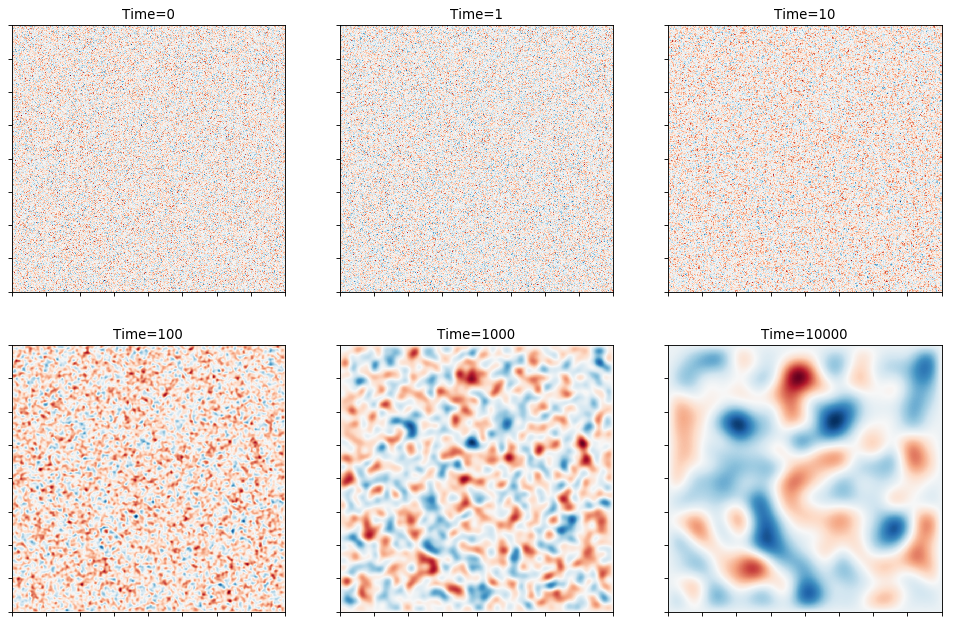

In [7]:
rm = TDGL()   # instantiate the class

# generate the grid and initialise the field
x = np.linspace(-1,1,N)
y = np.linspace(-1,1,N)
X, Y = np.meshgrid(x, y)

u=np.random.randn(N*N, 1);  # Initial data
L = rm.laplacian(N)         # construct the laplacian
rm.integrate(L, x, y, u)    # simulate

#simulation completed!!

 Thus we see that time evolution of the Monte carlo simulation of the Ising model and that of the TDGL equation are similar. The TDGL equation is a hydrodynamic model while the simulation of the Ising model was done at the molecular level. We still see a similarity in the time evolution, as expected!